# Covid-19 United States Growth Modeling

### Data Source:
#### 2019 Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering

Link: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import numpy.random as npr
import pandas as pd
from scipy.optimize import leastsq

import datetime
import warnings

from lib import get_or_update_source_data, logistic4, residuals, peval

warnings.filterwarnings('ignore')

In [2]:
get_or_update_source_data()

Updating source data


In [3]:
df = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv') 

## Report Update Information:

In [4]:
print(f'Report Generated On:\t\t{datetime.datetime.now().strftime("%m/%d/%y")}\nData Source Updated On:\t\t{df.columns[-1]}')

Report Generated On:		03/18/20
Data Source Updated On:		3/18/20


### On 3/10/20, data stopped being reported by county and began reporting at the state level:

Source: https://github.com/CSSEGISandData/COVID-19/issues/382

In [5]:
us_states_by_county = df[(df["Country/Region"]=='US') & (df["Province/State"].str.contains(','))]

In [6]:
us_states = df[(df["Country/Region"]=='US') & (df["Province/State"].str.contains(',').apply(lambda x: not x))]

In [7]:
states_sum_by_county = us_states_by_county.sum().to_frame().drop(["Province/State", "Country/Region", "Lat", "Long"])
states_sum_by_county = states_sum_by_county[(states_sum_by_county[0]!=0)]
states_sum_by_county.columns = ["Confirmed Cases"]
states_sum_by_county.index = [datetime.datetime.strptime(index, "%m/%d/%y") for index in states_sum_by_county.index]

In [8]:
states_sum = us_states.sum().to_frame().drop(["Province/State", "Country/Region", "Lat", "Long"])
states_sum = states_sum[(states_sum[0]!=0)]
states_sum.columns = ["Confirmed Cases"]
states_sum.index = [datetime.datetime.strptime(index, "%m/%d/%y") for index in states_sum.index]

In [9]:
totals = pd.concat([states_sum_by_county.loc[:'2020-03-9'], states_sum.loc['2020-03-10':]], axis=0)

# Data and Graphs:

### Follows typical exponential growth starting around Feb 23rd:

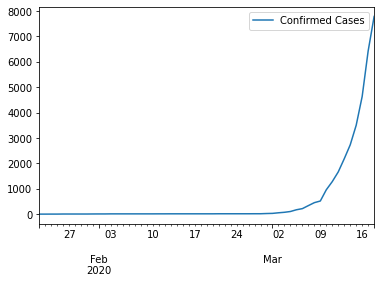

In [10]:
totals.plot()

### Viewing growth from a log scale:

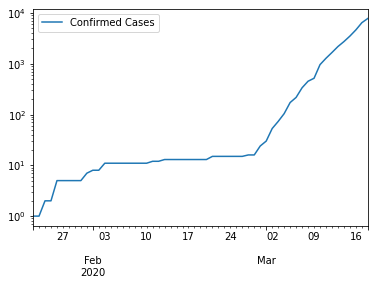

In [11]:
totals.plot(logy=True)

### Data in Numbers - US Confirmed Cases (From Feb 23rd):

In [12]:
totals = totals.loc['2020-02-28':]
totals

,Confirmed Cases
2020-02-28,16
2020-02-29,24
2020-03-01,30
2020-03-02,53
2020-03-03,73
2020-03-04,104
2020-03-05,172
2020-03-06,217
2020-03-07,336
2020-03-08,452


# Generating Lines of Best Fit:

### We can see that fitting to the data seems to work pretty well

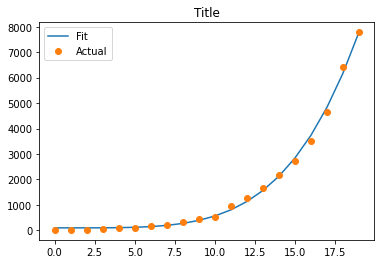

In [13]:
x = np.array(range(len(totals.index)))
y_meas = totals['Confirmed Cases'].astype(float)

# Initial guess for parameters
p0 = [0, 1, 1, 1]

# Fit equation using least squares optimization
plsq = leastsq(residuals, p0, args=(y_meas, x))

x_hat = np.array(range(len(totals.index)))
plt.plot(x_hat,peval(x_hat,plsq[0]),x,y_meas,'o')
plt.title('Title')
plt.legend(['Fit', 'Actual'], loc='upper left')

## And with a log scale:

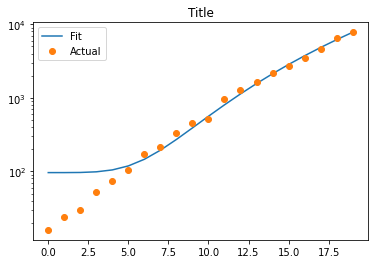

In [14]:
plt.plot(x_hat,peval(x_hat,plsq[0]),x,y_meas,'o')
plt.title('Title')
plt.legend(['Fit', 'Actual'], loc='upper left')
plt.yscale('log')

# Projections:

### Note: These projections are only estimations, and represent my opinions and mine alone. 

For Official Coronavirus information please visit https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports/

### We use a logistic growth model to calculate our projections
Unlike exponential growth, logistic growth tapers off over time:
![title](assets/logistic_growth.png)

### Plot results with predictions for ten days into the future:

In [15]:
num_pred_days = 10

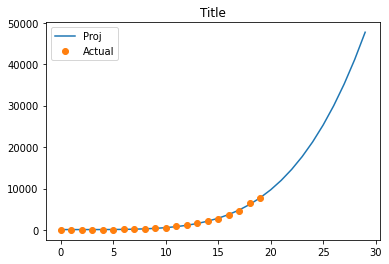

In [16]:
x_hat = np.array(range(len(totals.index) + num_pred_days))
plt.plot(x_hat,peval(x_hat,plsq[0]),x,y_meas,'o')
plt.title('Title')
plt.legend(['Proj', 'Actual'], loc='upper left')

### Projections in numbers:

In [17]:
proj = pd.DataFrame(peval(x_hat,plsq[0]))
proj['Actual'] = np.concatenate((np.array(y_meas), np.array([np.NaN for _ in range(num_pred_days)])), axis=0)
proj.index = [datetime.date(2020,2,28) + datetime.timedelta(days=x) for x in range(len(x_hat))]
proj.columns = ['Proj', 'Actual']
proj['Proj Growth'] = [max(list(proj['Proj'])[idx] - list(proj['Proj'])[idx - 1], 0.0) for idx, _ in enumerate(list(proj['Proj']))]
proj['Actual Growth'] = [max(y_meas[idx] - y_meas[idx - 1], 0.0) for idx, _ in enumerate(list(y_meas))] + [np.NaN for _ in range(num_pred_days)]
proj['Actual / Proj Diff'] = proj['Actual'] - proj['Proj']
proj['Actual / Proj Growth Diff'] = proj['Actual Growth'] - proj['Proj Growth']
proj.astype(object).fillna("TBD")

,Proj,Actual,Proj Growth,Actual Growth,Actual / Proj Diff,Actual / Proj Growth Diff
2020-02-28,96.208594,16,0.000000,0,-80.2086,0
2020-02-29,96.228150,24,0.019556,8,-72.2282,7.98044
2020-03-01,96.614769,30,0.386619,6,-66.6148,5.61338
2020-03-02,98.603916,53,1.989148,23,-45.6039,21.0109
2020-03-03,104.644827,73,6.040910,20,-31.6448,13.9591
2020-03-04,118.609471,104,13.964644,31,-14.6095,17.0354
2020-03-05,145.958115,172,27.348645,68,26.0419,40.6514
2020-03-06,193.879157,217,47.921042,45,23.1208,-2.92104
2020-03-07,271.410906,336,77.531750,119,64.5891,41.4683
2020-03-08,389.549226,452,118.138320,116,62.4508,-2.13832


In [18]:
print(f"The model predicts {round(proj['Proj'][datetime.date.today()])} confirmed cases by the end of today.")
print(f"The model predicts {round(proj['Proj'][-1])} confirmed cases in ten day's time.")

The model predicts 7778.0 confirmed cases by the end of today.
The model predicts 47709.0 confirmed cases in ten day's time.


# Today's end-of-day results:

In [19]:
df = pd.read_csv(f'COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/{(datetime.datetime.now()).strftime("%m-%d-%Y")}.csv') 
us = df[(df["Country/Region"]=='US')]
us.sort_values("Province/State").reset_index(drop=True)

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Alabama,US,2020-03-18T19:33:03,46,0,0,32.3182,-86.9023
1,Alaska,US,2020-03-18T05:53:25,6,0,0,61.3707,-152.4044
2,Arizona,US,2020-03-18T19:33:03,27,0,0,33.7298,-111.4312
3,Arkansas,US,2020-03-18T19:33:03,33,0,0,34.9697,-92.3731
4,California,US,2020-03-18T19:14:34,751,13,0,36.1162,-119.6816
5,Colorado,US,2020-03-18T15:53:09,184,2,0,39.0598,-105.3111
6,Connecticut,US,2020-03-17T23:13:10,68,0,0,41.5978,-72.7554
7,Delaware,US,2020-03-18T19:33:03,19,0,0,39.3185,-75.5071
8,Diamond Princess,US,2020-03-16T16:53:06,47,0,0,35.4437,139.6380
9,District of Columbia,US,2020-03-18T05:53:25,31,0,0,38.8974,-77.0268


In [20]:
us_totals = us.sum().to_frame().drop(["Province/State", "Country/Region", "Last Update", "Latitude", "Longitude"])
us_totals

,0
Confirmed,7786
Deaths,118
Recovered,106


In [21]:
c = us_totals[0]['Confirmed']
d = us_totals[0]['Deaths']
print(f'US mortality rate as of the end of today: {round((d/c) * 100, 2)}%')

US mortality rate as of the end of today: 1.52%
